# Performance and Accuracy Analysis of PyTorch Models using Torch-TensorRT

**Objective:**

This notebook evaluates the impact of **Torch-TensorRT** on inference performance and numerical accuracy of a PyTorch-based Transformer model. We compare baseline PyTorch execution against TensorRT-accelerated execution under different precision modes, focusing on real-world deployment considerations such as latency, throughput, and stability.



**Benchmarking Methodology:**

Accurate GPU benchmarking requires care:

- CUDA operations are asynchronous
- Timing must include explicit synchronization
- Multiple runs are averaged to reduce variance

We measure:
- **Latency per inference**
- **Relative speedup compared to PyTorch**

This methodology mirrors production inference profiling practices.

## Environment Assumptions

This notebook assumes:
- An NVIDIA GPU with CUDA support
- Compatible versions of PyTorch, CUDA, and TensorRT
- Torch-TensorRT installed correctly

Torch-TensorRT relies on TensorRT under the hood, which means:
- Only **static or mostly-static computation graphs** are supported
- Some PyTorch operations may fall back to native execution if unsupported


In [ ]:
# Uninstall everything completely
!pip uninstall -y torch torchvision torchaudio torch-tensorrt nvidia-tensorrt

# Force install PyTorch for CUDA 12.4 (matching your nvidia-smi)
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124

In [ ]:
# Install TensorRT for CUDA 12.4
!pip install torch-tensorrt==2.5.0 --extra-index-url https://download.pytorch.org/whl/cu124

In [1]:
import torch
import torch_tensorrt

print(f"PyTorch: {torch.__version__}")
print(f"PyTorch CUDA: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"TensorRT: {torch_tensorrt.__version__}")

PyTorch: 2.5.1+cu124
PyTorch CUDA: 12.4
CUDA available: True
TensorRT: 2.5.0+cu124


## Model Architecture

We use a lightweight Transformer-style model to evaluate Torch-TensorRT.  
This choice is intentional:

- Transformers contain **matrix multiplications and attention blocks** that benefit from TensorRT kernel fusion
- The architecture is complex enough to expose graph compilation behavior
- Yet small enough to benchmark quickly in a notebook environment

This model serves as a proxy for larger sequence models used in production.


In [ ]:
import time
from transformers import AutoTokenizer, AutoModel

# 1. Load model & tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).eval().cuda()

# 2. Example batch of sentences
text = """ A good story encourages us to turn the next page and read more. We want to find out what happens next and what the main characters do and what they say to each other.
We may feel excited, sad, afraid, angry or really happy. This is because the experience of reading or listening to a story is much more likely to make us 'feel' that we are part
of the story, too. Just like in our 'real' lives, we might love or hate different characters in the story. Perhaps we recognise ourselves or others in some of them. Perhaps we
have similar problems. Because of this natural empathy with the characters, our brains process the reading of stories differently from the way we read factual information.
Our brains don't always recognise the difference between an imagined situation and a real one so the characters become 'alive' to us. What they say and do is therefore more meaningful.
This is why the words and structures that relate a story's events, descriptions and conversations are processed in this deeper way. In fact, cultures all around the world have always
used storytelling to pass knowledge from one generation to another. Our ancestors understood very well that this was the best way to make sure our histories and information about
how to relate to others and to our world was not only understood, but remembered too. (Notice that the word ‘history’ contains the word ‘story’ – More accurately, the word ‘story’
derives from ‘history’.) Encouraging your child to read or listen to stories should therefore help them to learn a second language in a way that is not only fun, but memorable.
Let's take a quick look at learning vocabulary within a factual text or within a story. Imagine the readers are eight-year-olds interested in animals. In your opinion, are they more
likely to remember AND want to continue reading the first or second text? """

texts = [item.strip() for item in text.split(".")][:16]  # adjust batch size here
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=32).to("cuda")

input_ids = inputs["input_ids"].to(torch.int32)
attention_mask = inputs["attention_mask"].to(torch.int32)


## Baseline: Native PyTorch Inference

We first measure inference performance using standard PyTorch execution.

Important benchmarking details:
- The model is set to `eval()` mode
- Gradients are disabled
- GPU synchronization is required for accurate timing
- Initial iterations are treated as warm-up runs

This baseline establishes a reference point for evaluating TensorRT speedups.


In [3]:
# 3. Baseline PyTorch inference

with torch.no_grad():
    start = time.time()
    baseline_outputs = model(input_ids, attention_mask)
    torch.cuda.synchronize()
    end = time.time()
    baseline_time = end - start
    print(f"PyTorch latency: {baseline_time:.4f} sec")

print("Output shape (PyTorch):", baseline_outputs.last_hidden_state.shape)

PyTorch latency: 0.1872 sec
Output shape (PyTorch): torch.Size([16, 32, 768])


## Torch-TensorRT Compilation

Torch-TensorRT converts a PyTorch module into a TensorRT-backed execution engine.

Key steps:
1. Trace or lower the PyTorch graph
2. Identify TensorRT-supported subgraphs
3. Optimize kernels, fuse layers, and select precision
4. Produce a compiled module callable like a PyTorch model

Not all PyTorch operations are supported. Unsupported ops remain in PyTorch and may reduce speedup.


**Precision Configuration:**

We evaluate performance under different numerical precisions:

- **FP32**: Highest numerical fidelity, lowest speed
- **FP16**: Faster execution using Tensor Cores, minimal accuracy loss

Lower precision improves:
- Throughput
- Memory bandwidth utilization
- Kernel efficiency

Accuracy is evaluated to ensure numerical stability is preserved.

In [4]:
# 4.1 Convert model with Torch-TensorRT with enabled_precision of torch.float16

trt_model_float16 = torch_tensorrt.compile(
    model,
    inputs=[
        torch_tensorrt.Input(min_shape=[1, 32], opt_shape=[8, 32], max_shape=[16, 32], dtype=torch.int32),  # input_ids
        torch_tensorrt.Input(min_shape=[1, 32], opt_shape=[8, 32], max_shape=[16, 32], dtype=torch.int32),  # attention_mask
    ],
    enabled_precisions={torch.float16},
)

trt_inputs = {
    "input_ids": input_ids,
    "attention_mask": attention_mask
}

print("Convert to TensorRT (FP16).")

  getattr_node = gm.graph.get_attr(lifted_node)

  warnings.warn(f'Node {node} target {node.target} {atom} of {seen_qualname} does '



Convert to TensorRT (FP16).


In [5]:
# 4.2 Convert model with Torch-TensorRT with enabled_precision of torch.float32

trt_model_float32 = torch_tensorrt.compile(
    model,
    inputs=[
        torch_tensorrt.Input(min_shape=[1, 32], opt_shape=[8, 32], max_shape=[16, 32], dtype=torch.int32),  # input_ids
        torch_tensorrt.Input(min_shape=[1, 32], opt_shape=[8, 32], max_shape=[16, 32], dtype=torch.int32),  # attention_mask
    ],
    enabled_precisions={torch.float32},
)

trt_inputs_float32 = {
    "input_ids": input_ids,
    "attention_mask": attention_mask
}

print("Convert to TensorRT (FP32).")

  getattr_node = gm.graph.get_attr(lifted_node)

  warnings.warn(f'Node {node} target {node.target} {atom} of {seen_qualname} does '



Convert to TensorRT (FP32).


## TensorRT-Accelerated Inference

After compilation, inference is executed using the TensorRT engine.

Key observations to expect:
- Reduced latency due to kernel fusion
- More stable execution times
- Higher GPU utilization

Speedup depends on:
- Graph coverage by TensorRT
- Input shape stability
- Precision mode


In [6]:
# 5.1 Run model trt_model_float16

start = time.time()
trt_outputs_float16 = trt_model_float16(**trt_inputs)
torch.cuda.synchronize()
end = time.time()
trt_time_float16 = end - start
print(f"Torch-TensorRT latency: {trt_time_float16:.4f} sec")

print("Output shape (TensorRT):", trt_outputs_float16.last_hidden_state.shape)

Torch-TensorRT latency: 0.0272 sec
Output shape (TensorRT): torch.Size([16, 32, 768])


In [7]:
# 5.2 Run model trt_model_float32

start = time.time()
trt_outputs_float32 = trt_model_float32(**trt_inputs_float32)
torch.cuda.synchronize()
end = time.time()
trt_time_float32 = end - start
print(f"Torch-TensorRT latency: {trt_time_float32:.4f} sec")

print("Output shape (TensorRT):", trt_outputs_float32.last_hidden_state.shape)

Torch-TensorRT latency: 0.0429 sec
Output shape (TensorRT): torch.Size([16, 32, 768])


## Performance Comparison

Performance gains are meaningless without correctness. We compare:
- PyTorch outputs
- Torch-TensorRT outputs

Metrics:
- Absolute difference
- Relative error tolerance
- Error Distribution Analysis (KDE Plot)

Small numerical deviations are expected in FP16 mode and are generally acceptable for inference workloads.


### Inference: Numerical Difference

In [34]:
def compare_outputs(baseline, trt_output, precision_name, threshold=0.01):
    """Compare baseline and TensorRT outputs"""
    diff_tensor = torch.abs(baseline.last_hidden_state - trt_output.last_hidden_state)

    max_diff = diff_tensor.max().item()
    mean_diff = diff_tensor.mean().item()
    percent_over_threshold = (diff_tensor > threshold).float().mean().item() * 100

    print(f"\n{precision_name} Comparison:")
    print(f"  Max absolute difference: {max_diff:.6f}")
    print(f"  Mean absolute difference: {mean_diff:.6f}")
    print(f"  Elements > {threshold}: {percent_over_threshold:.2f}%")

    return diff_tensor, max_diff, mean_diff, percent_over_threshold

In [35]:
# Compare FP16
fp16_stats = compare_outputs(baseline_outputs, trt_outputs_float16, "FP16")


FP16 Comparison:
  Max absolute difference: 4.807189
  Mean absolute difference: 0.076408
  Elements > 0.01: 68.02%


In [36]:
# Compare FP32
fp32_stats = compare_outputs(baseline_outputs, trt_outputs_float32, "FP32")


FP32 Comparison:
  Max absolute difference: 4.802082
  Mean absolute difference: 0.076205
  Elements > 0.01: 68.01%


### Inference: Time Difference

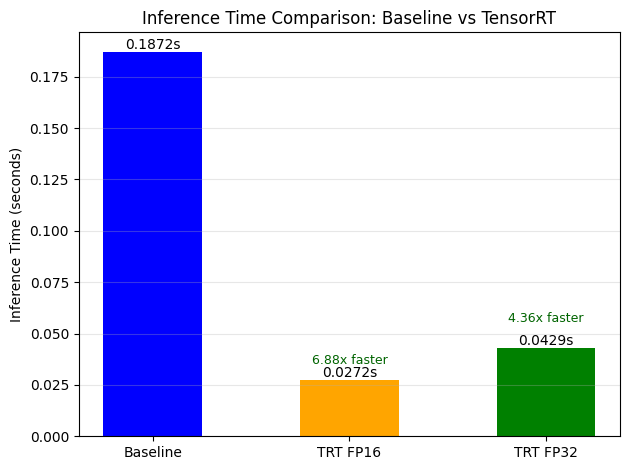

In [28]:
import matplotlib.pyplot as plt

inference_time = [baseline_time, trt_time_float16, trt_time_float32]
labels = ['Baseline', 'TRT FP16', 'TRT FP32']

# Create bar chart
bars = plt.bar(labels, inference_time, width=0.5, color=['blue', 'orange', 'green'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}s',
             ha='center', va='bottom', fontsize=10)

# Add speedup annotations
speedup_fp16 = baseline_time / trt_time_float16
speedup_fp32 = baseline_time / trt_time_float32
plt.text(1, trt_time_float16 * 1.3, f'{speedup_fp16:.2f}x faster',
         ha='center', fontsize=9, color='darkgreen')
plt.text(2, trt_time_float32 * 1.3, f'{speedup_fp32:.2f}x faster',
         ha='center', fontsize=9, color='darkgreen')

plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Baseline vs TensorRT')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Result Interpretation

Typical outcomes:
- FP16 Torch-TensorRT yields significant latency reduction
- Speedup increases with model complexity and batch size

If speedup is low, common reasons include:
- Unsupported operations
- Dynamic control flow
- Small model size (overhead dominates)

In [32]:
import pandas as pd
import numpy as np

data_comparison = pd.DataFrame({
    "Configure": ['PyTorch Baseline', 'TensorRT FP16', 'TensorRT FP32'],
    "Inference Time (s)": [baseline_time, trt_time_float16, trt_time_float32],
    "Max Difference": [np.nan, fp16_stats[1], fp32_stats[1]],
    "Above Threshold % (0.01)": [np.nan, fp16_stats[3], fp32_stats[3]]
}).set_index('Configure')

data_comparison

,Inference Time (s),Max Difference,Above Threshold % (0.01)
Configure,,,
PyTorch Baseline,0.187200,NaN,NaN
TensorRT FP16,0.027192,4.807189,68.018597
TensorRT FP32,0.042916,4.802082,68.007916


**Error Distribution Analysis**

The KDE (Kernel Density Estimation) plot visualizes the distribution of absolute differences between baseline and TensorRT model outputs, where peaks indicate the most common error magnitudes. Both FP16 and FP32 show similar distributions concentrated near zero, suggesting minimal accuracy loss from TensorRT optimization while achieving significant speedup.

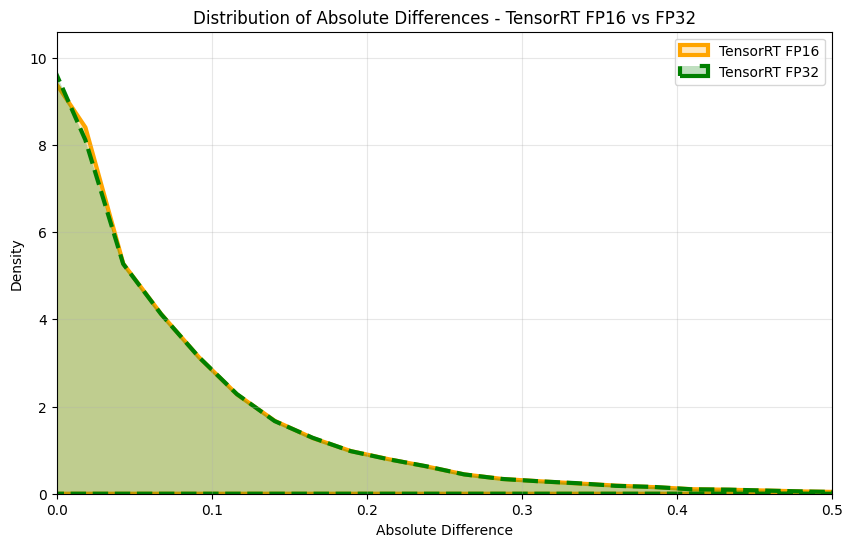

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

diff_flat_float16 = fp16_stats[0].flatten().cpu().numpy()
diff_flat_float32 = fp32_stats[0].flatten().cpu().numpy()

plt.figure(figsize=(10, 6))
sns.kdeplot(diff_flat_float16, label="TensorRT FP16", fill=True, color="orange", linewidth=3)
sns.kdeplot(diff_flat_float32, label="TensorRT FP32", fill=True, color="green", linewidth=3, linestyle='--')

plt.xlim(0, 0.5)
plt.xlabel("Absolute Difference")
plt.ylabel("Density")
plt.title("Distribution of Absolute Differences - TensorRT FP16 vs FP32")
plt.legend()
plt.grid(alpha=0.3)
plt.show()